I will explore how we can use maximum entropy prior corrections from [Handley & Millea (2019)](http://arxiv.org/abs/1804.08143) to impose flat priors on galaxy properties **while imposing Dirichlet priors on the SFH basis coefficients $\{\beta_i\}$**. We want to impose Dirichlet priors on these coefficients because that's more physically motivated. 

In [1]:
import os, h5py
import numpy as np 
from scipy.stats import gaussian_kde as gkde

from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

Sample $\{b_i\}$ from Dirichlet prior using the warped manifold transformation

In [3]:
n_sample = 100000
bp1 = np.random.uniform(size=n_sample)
bp2 = np.random.uniform(size=n_sample)
bp3 = np.random.uniform(size=n_sample)
bp4 = np.random.uniform(size=n_sample)

ispec = Fitters.iSpeculator()

# warped manifold transform
beta_arr = ispec._transform_to_SFH_basis(np.array([bp1, bp2, bp3, bp4]).T)
# betas
b1, b2, b3, b4 = beta_arr.T

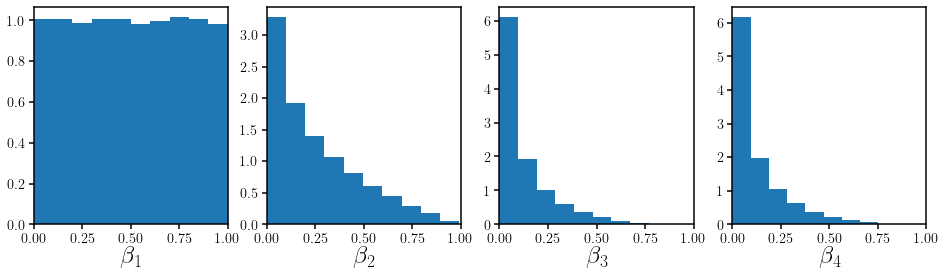

In [4]:
fig = plt.figure(figsize=(16,4))
for i, _y in enumerate([b1, b2, b3, b4]): 
    sub = fig.add_subplot(1,4,i+1)
    sub.hist(_y, density=True)
    sub.set_xlim(0., 1)
    sub.set_xlabel(r'$\beta_{%i}$' % (i+1), fontsize=25)

Now lets derivate SSFRs based on the SFH bases

In [5]:
ssfr_1gyr = ispec.get_SFR(np.array([np.ones(len(b1)), b1, b2, b3, b4]), 0.1, dt=1.)
ssfr_100myr = ispec.get_SFR(np.array([np.ones(len(b1)), b1, b2, b3, b4]), 0.1, dt=0.1)

logssfr_1gyr = np.log10(ssfr_1gyr)
logssfr_100myr = np.log10(ssfr_100myr)

(0.0, 3e-09)

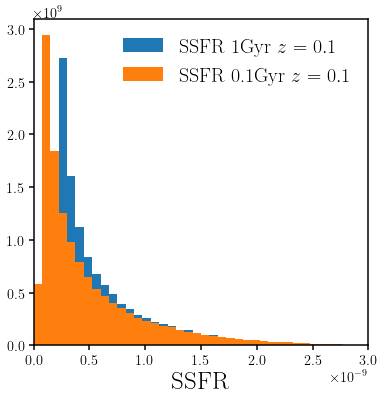

In [6]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(ssfr_1gyr, range=[0, 3e-9], bins=40, density=True, label='SSFR 1Gyr $z=0.1$')
sub.hist(ssfr_100myr, range=[0, 3e-9], bins=40, density=True, label='SSFR 0.1Gyr $z=0.1$')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}$', fontsize=25)
sub.set_xlim(0, 3e-9)

Now lets fits a KDE to $p({\rm SSFR})$

In [7]:
kde_ssfr1gyr = gkde(ssfr_1gyr * 1e9)

In [8]:
kde_sample = kde_ssfr1gyr.resample(1000).flatten()

(0.0, 3e-09)

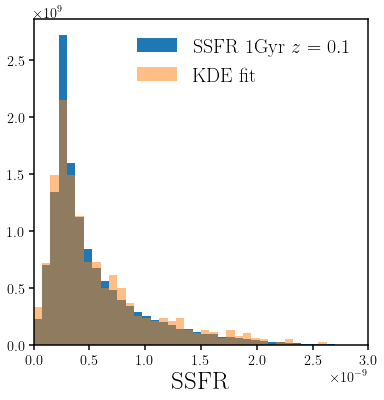

In [9]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(ssfr_1gyr,  range=[0, 3e-9], bins=40, density=True, label='SSFR 1Gyr $z=0.1$')
sub.hist(kde_sample.flatten() / 1e9, range=[0, 3e-9], bins=40, density=True, alpha=0.5, label='KDE fit')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}$', fontsize=25)
sub.set_xlim(0, 3e-9)

Now lets calculate the weights to assign the samples to get a flat $p({\rm SSFR})$

In [10]:
w_ssfr1gyr = 1./kde_ssfr1gyr.pdf(ssfr_1gyr * 1e9)

(0.0, 3e-09)

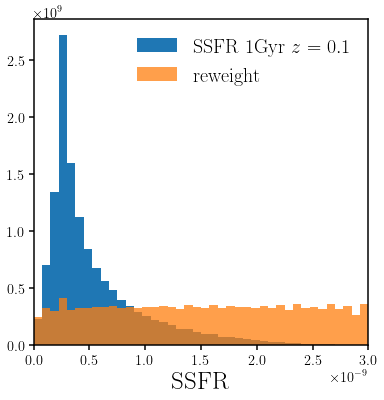

In [11]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(ssfr_1gyr, range=[0, 3e-9], bins=40, density=True, label='SSFR 1Gyr $z=0.1$')
sub.hist(ssfr_1gyr, weights=w_ssfr1gyr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='reweight')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}$', fontsize=25)
sub.set_xlim(0, 3e-9)

In [12]:
kde_ssfr100myr = gkde(ssfr_100myr * 1e9)
w_ssfr100myr = 1./kde_ssfr100myr.pdf(ssfr_100myr * 1e9)

(0.0, 3e-09)

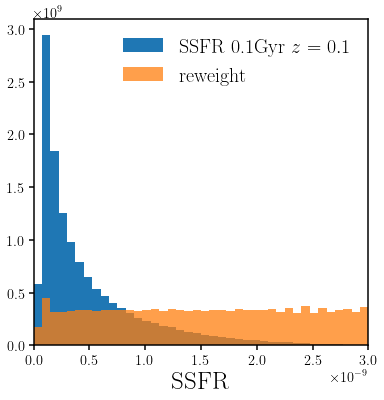

In [13]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(ssfr_100myr, range=[0, 3e-9], bins=40, density=True, label='SSFR 0.1Gyr $z=0.1$')
sub.hist(ssfr_100myr, weights=w_ssfr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='reweight')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}$', fontsize=25)
sub.set_xlim(0, 3e-9)

How about for $\log {\rm SSFR}$

(-11.0, -8.0)

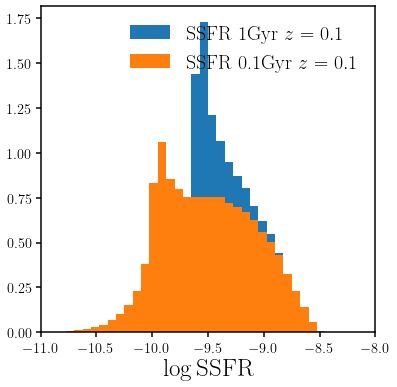

In [14]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(logssfr_1gyr, range=[-11, -8], bins=40, density=True, label='SSFR 1Gyr $z=0.1$')
sub.hist(logssfr_100myr, range=[-11, -8], bins=40,density=True, color='C1', label='SSFR 0.1Gyr $z=0.1$')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'$\log {\rm SSFR}$', fontsize=25)
sub.set_xlim(-11, -8)

In [15]:
kde_logssfr1gyr = gkde(logssfr_1gyr)
w_logssfr1gyr = 1./kde_logssfr1gyr.pdf(logssfr_1gyr)

kde_logssfr100myr = gkde(logssfr_100myr)
w_logssfr100myr = 1./kde_logssfr100myr.pdf(logssfr_100myr)

(-11.0, -8.0)

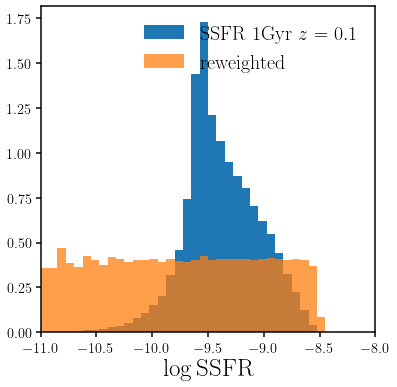

In [16]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(logssfr_1gyr, range=[-11, -8], bins=40, density=True, label='SSFR 1Gyr $z=0.1$')
sub.hist(logssfr_1gyr, weights=w_logssfr1gyr, range=[-11, -8], bins=40,density=True, color='C1', alpha=0.75, label='reweighted')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'$\log {\rm SSFR}$', fontsize=25)
sub.set_xlim(-11, -8)

(-11.0, -8.0)

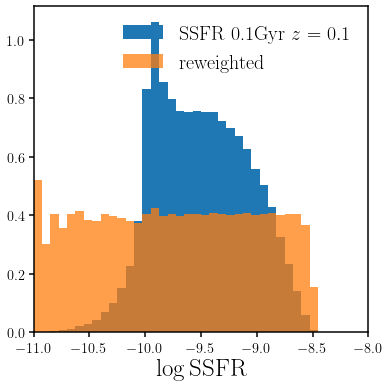

In [17]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(logssfr_100myr, range=[-11, -8], bins=40, density=True, label='SSFR 0.1Gyr $z=0.1$')
sub.hist(logssfr_100myr, weights=w_logssfr100myr, range=[-11, -8], bins=40,density=True, color='C1', alpha=0.75, label='reweighted')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'$\log {\rm SSFR}$', fontsize=25)
sub.set_xlim(-11, -8)